In [45]:
# Import necessary libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.optimize as sci_plt
from sklearn.preprocessing import StandardScaler
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Read the CSV files
df1 = pd.read_csv('COL.csv')
df1['symbol'] = "COL"
df2 = pd.read_csv('CHC.csv')
df2['symbol'] = "CHC"
df3 = pd.read_csv('CIM.csv')
df3['symbol'] = "CIM"
df4 = pd.read_csv('COH.csv')
df4['symbol'] = "COH"
df5 = pd.read_csv('CPU.csv')
df5['symbol'] = "CPU"

# Concatenate all dataframes into one
df = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)

# Keep only necessary columns
df = df[['Date', 'symbol', 'Close']]

# Pivot the data to make symbols the headers
df = df.pivot(index='Date', columns='symbol', values='Close')
display(df)

# Fill missing values by forward fill and then backward fill
df = df.ffill().bfill()

# Calculate the log returns
log_return = np.log(1 + df.pct_change())

# Calculate expected returns and sample covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for the maximum Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Optimized Weights:", cleaned_weights)

# Calculate the expected performance of the portfolio
portfolio_performance = ef.portfolio_performance(verbose=True)
print("Expected Portfolio Performance (Return, Risk, Sharpe Ratio):", portfolio_performance)

# Discrete allocation of the stocks
latest_prices = get_latest_prices(df)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

# Prepare detailed results
stock_counts = {k: v for k, v in allocation.items()}
stock_prices = {symbol: latest_prices.loc[symbol] for symbol in allocation.keys()}
investments = {symbol: count * stock_prices[symbol] for symbol, count in stock_counts.items()}
total_investment = sum(investments.values())

# Print detailed results
print("\nDetailed Results:")
print("Stock Counts:", stock_counts)
print("Stock Prices:", stock_prices)
print("Investments per Stock:", investments)
print("Total Investment:", total_investment)
print("Capital Remaining:", leftover)
print("Expected Return:", portfolio_performance[0])
print("Expected Risk:", portfolio_performance[1])
print("Sharpe Ratio:", portfolio_performance[2])


symbol,CHC,CIM,COH,COL,CPU
Date,,,,,
2000-01-04,NaN,5.601420,19.450001,NaN,7.60
2000-01-05,NaN,5.562860,18.959999,NaN,7.20
2000-01-06,NaN,5.553220,19.400000,NaN,7.15
2000-01-07,NaN,5.746040,18.799999,NaN,6.51
2000-01-10,NaN,5.611070,19.450001,NaN,7.23
...,...,...,...,...,...
2020-03-26,6.35,24.100000,182.169998,16.549999,9.22
2020-03-27,6.36,21.700001,166.470001,15.730000,9.03
2020-03-30,6.58,22.850000,182.809998,16.820000,9.71


Optimized Weights: OrderedDict({'CHC': np.float64(0.04756), 'CIM': np.float64(0.16126), 'COH': np.float64(0.79119), 'COL': np.float64(0.0), 'CPU': np.float64(0.0)})
Expected annual return: 10.8%
Annual volatility: 26.4%
Sharpe Ratio: 0.33
Expected Portfolio Performance (Return, Risk, Sharpe Ratio): (np.float64(0.108359735914783), np.float64(0.2644574555665601), np.float64(0.33411701600730304))
Discrete allocation: {'CHC': np.int64(67), 'CIM': np.int64(69), 'COH': np.int64(40), 'COL': np.int64(1), 'CPU': np.int64(3)}
Funds remaining: $23.13

Detailed Results:
Stock Counts: {'CHC': np.int64(67), 'CIM': np.int64(69), 'COH': np.int64(40), 'COL': np.int64(1), 'CPU': np.int64(3)}
Stock Prices: {'CHC': np.float64(7.2), 'CIM': np.float64(23.6), 'COH': np.float64(195.5), 'COL': np.float64(15.83), 'CPU': np.float64(10.08)}
Investments per Stock: {'CHC': np.float64(482.40000000000003), 'CIM': np.float64(1628.4), 'COH': np.float64(7820.0), 'COL': np.float64(15.83), 'CPU': np.float64(30.24000000000

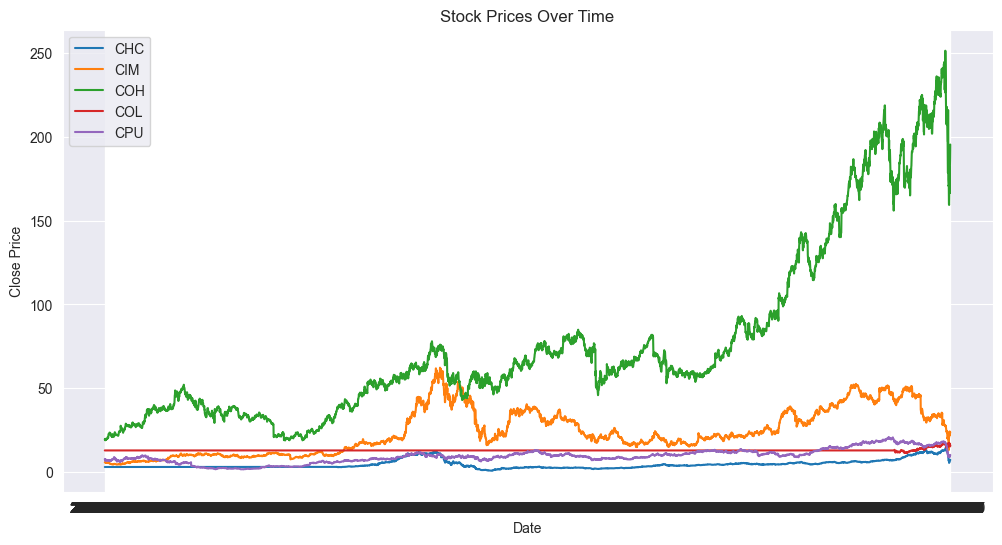

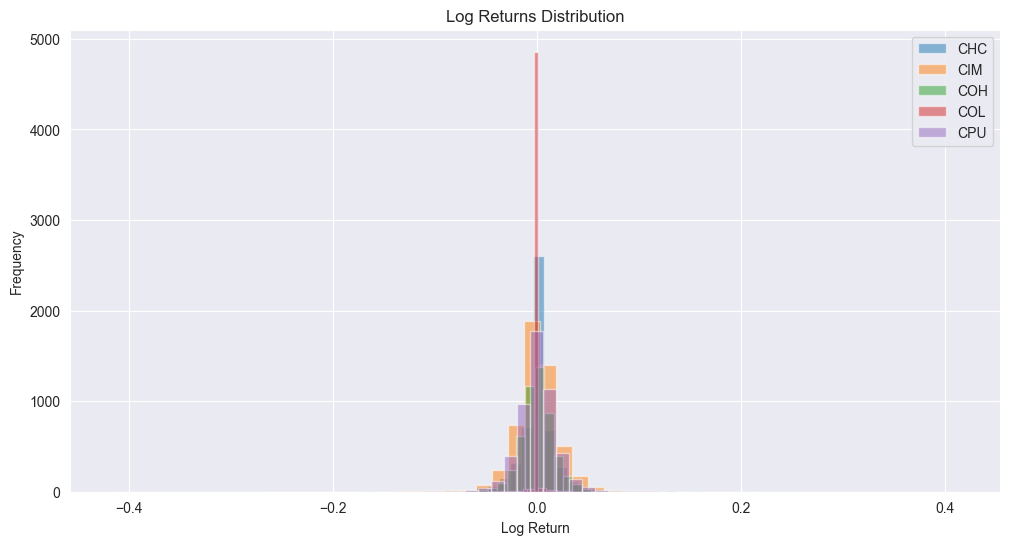

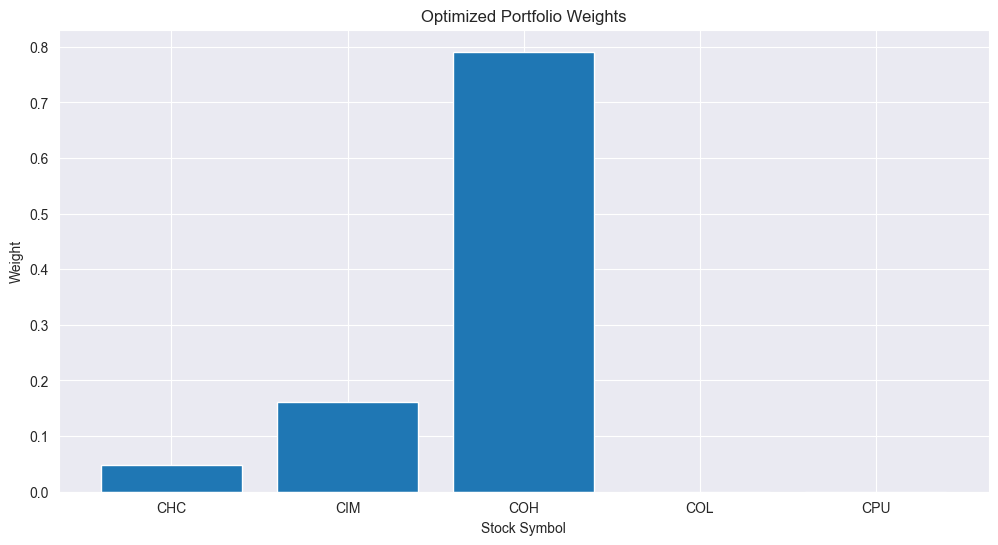

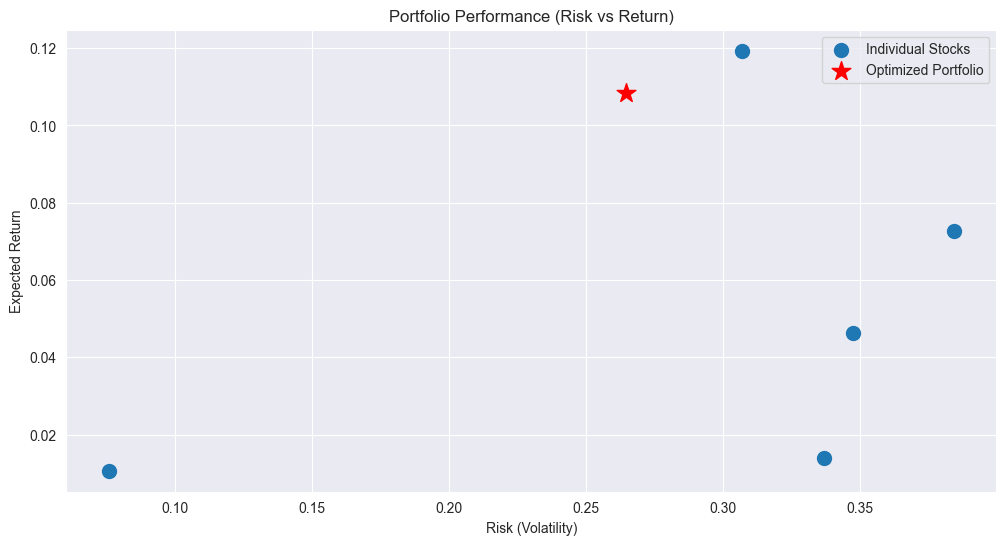

In [49]:
# Plotting

# 1. Stock Prices Over Time
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 2. Log Returns Distribution
plt.figure(figsize=(12, 6))
for col in log_return.columns:
    plt.hist(log_return[col].dropna(), bins=50, alpha=0.5, label=col)
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Log Returns Distribution')
plt.legend()
plt.grid(True)
plt.show()

# 3. Optimized Portfolio Weights
plt.figure(figsize=(12, 6))
plt.bar(cleaned_weights.keys(), cleaned_weights.values())
plt.xlabel('Stock Symbol')
plt.ylabel('Weight')
plt.title('Optimized Portfolio Weights')
plt.grid(True)
plt.show()

# 4. Portfolio Performance (Risk vs Return)
individual_risks = np.sqrt(np.diag(S))
individual_returns = mu

plt.figure(figsize=(12, 6))
plt.scatter(individual_risks, individual_returns, marker='o', s=100, label='Individual Stocks')
plt.scatter(portfolio_performance[1], portfolio_performance[0], marker='*', color='red', s=200, label='Optimized Portfolio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title('Portfolio Performance (Risk vs Return)')
plt.legend()
plt.grid(True)
plt.show()
